# FEA
Worked example - linear elastic bar in 1D

Import some libraries needed for numerical computing and plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Stiffness matrix for a single element e, Ke

In [22]:
def calculate_Ke(EI, le):
    return (EI / (le*le*le)) * np.array([[12, 6*le, -12, 6*le], 
                                     [6*le, 4*le*le, -6*le, 2*le*le], 
                                     [-12, -6*le, 12, -6*le], 
                                     [6*le, 2*le*le, -6*le, 4*le*le]]) / 1000
def calculate_fe(f, le):
    return f * le/2 * np.array([[1], [le/6], [1], [-le/6]])

def calculate_shape_function(epsilon, le):
    return np.array([[1/4*(2 + epsilon)*((1 - epsilon)**2)],
                     [le/8*((1 - epsilon)**2)*(1 + epsilon)],
                     [1/4*(2 - epsilon)*((1 + epsilon)**2)],
                     [le/8*((1 + epsilon)**2)*(epsilon - 1)]])

In [29]:
EI = 10000
le = 8
f = -1
epsilon = -1
point_load = 10
print(calculate_Ke(EI, le))
print()
print(calculate_fe(f, le))
print()
shape_function = calculate_shape_function(epsilon, le)
print(shape_function)
force_vector_point_load = point_load * shape_function
print()
print(force_vector_point_load)

[[ 0.234375  0.9375   -0.234375  0.9375  ]
 [ 0.9375    5.       -0.9375    2.5     ]
 [-0.234375 -0.9375    0.234375 -0.9375  ]
 [ 0.9375    2.5      -0.9375    5.      ]]

[[-4.        ]
 [-5.33333333]
 [-4.        ]
 [ 5.33333333]]

[[ 1.]
 [ 0.]
 [ 0.]
 [-0.]]

[[10.]
 [ 0.]
 [ 0.]
 [-0.]]


Function to compute the element stiffness matrix $\mathbf{K}^e =\dfrac{A^eE^e}{l^e}
	 \begin{bmatrix}
	 1	& -1 \\
	 -1	&	1
	 \end{bmatrix}$

In [4]:
  def get_Ke(Ae, Ee, le):
    return  (Ae * Ee / le) * np.array([[1., -1.], [-1., 1.]])

Function to compute the element body force vector $\mathbf{f}^e_\Omega = \dfrac{l^e}{6}
	 \begin{bmatrix}
	 2	& 1 \\
	 1	&	2
	 \end{bmatrix}
	 	 \begin{bmatrix}
	 b_1^e \\ b_2^e
	 \end{bmatrix}$

In [5]:
def get_fe_omega(le, b1, b2):
  return (le / 6.) * np.array([[2., 1.], [1., 2.]]).dot(np.array([[b1], [b2]]))

Function to return the global dofs for the element

In [6]:
def get_dof_index(e):
  return [e, e + 1]

Compute the strain from the displacement, $\dfrac{\mathsf{d}u^e(x)}{\mathsf{d} x} = \mathbf{B}^e \mathbf{d}^e$

In [7]:
  def get_strain_e(le, de):
    return  (1. / le) * np.array([-1., 1.]).dot(de)

Define the material properties and the loading

In [8]:
E = 8.   # Young's  modulus
l = 4.   # length of bar
A = 2.   # cross sectional area

b = 3.   # body force
t_bar = 1.   # applied traction

Determine the coordinates of the nodes $x$ based on the number of elements. Assume uniform spacing of the nodes.

In [9]:
n_el = 2   # number of elements
n_np = n_el + 1 # number of nodal points
x = np.linspace(0, l, n_np) # nodal coordinates
le = l / n_el  # length of element

In [10]:
print(n_el)
print(n_np)
print(x)

2
3
[0. 2. 4.]


Initialise the global stiffness matrix $\mathbf{K}$ and the force vector $\mathbf{f}$

In [11]:
K = np.zeros((n_np, n_np))
f = np.zeros((n_np, 1))

In [12]:
print(K)
print(f)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.]
 [0.]
 [0.]]


Loop over all the elements and assemble $\mathbf{K}$ and $\mathbf{f}$ from the element contributions

In [13]:
print(K)
for element in range(n_el):
    dof_index = get_dof_index(element)
    print(dof_index)
    print(get_Ke(A, E, le))
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(A, E, le)
    print(K)
    f[np.ix_(dof_index)] += get_fe_omega(le, b, b )

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[0, 1]
[[ 8. -8.]
 [-8.  8.]]
[[ 8. -8.  0.]
 [-8.  8.  0.]
 [ 0.  0.  0.]]
[1, 2]
[[ 8. -8.]
 [-8.  8.]]
[[ 8. -8.  0.]
 [-8. 16. -8.]
 [ 0. -8.  8.]]


Add the applied traction

In [14]:
f[-1] += t_bar * A 

Apply the boundary conditions and solve the problem

In [15]:
free_dof = np.arange(1,n_np)
K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]

# solve the linear system
d_free = np.linalg.solve(K_free,f_free)
d = np.zeros((n_np, 1))
d[1:] = d_free

In [16]:
print(free_dof)

[1 2]


Postprocessing. 
Compute the reaction force.
Display the structure of $\mathbf{K}$.
Plot the stress distribution.

The exact solution is given by $u^{\text{ex}} = -\dfrac{3}{32}x^2 + \dfrac{7}{8}x$ and 
$\sigma^\text{ex} = -\dfrac{3}{2}x + 7 = \bar{t} + \dfrac{b(l-x)}{A}$.

Reaction force  [-14.]


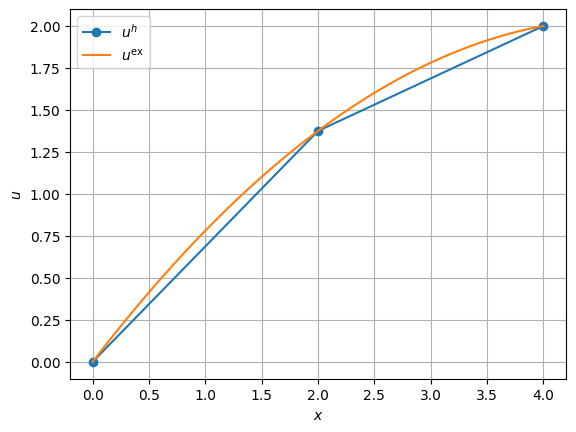

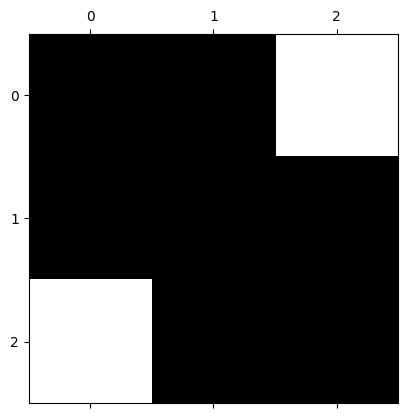

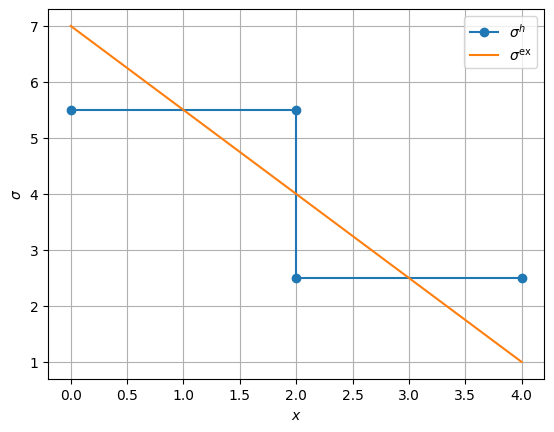

In [17]:
r = K[0,:].dot(d) - f[0]

print('Reaction force ', r)

x_ex = np.linspace(0, l, 100*n_el) # nodal coordinates
u_ex = -(3/32)*np.power(x_ex,2) + (7/8)*x_ex
stress_ex = (-3/2)*x_ex + 7

line1, = plt.plot(x, d, label = '$u^h$', marker = 'o')
line2, = plt.plot(x_ex, u_ex, label = '$u^\mathrm{ex}$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend(handles=[line1, line2])
plt.grid(True)
plt.show()

plt.spy(K)
plt.show()

x_post = np.zeros((2 * n_el))
x_post[0::2] = x[0:-1]
x_post[1::2] = x[1:]
stress_post = np.zeros((2 * n_el))
# compute the strain in each element
for ee in range(n_el):
    dof_index = get_dof_index(ee)
    index = [2 * ee, 2 * ee + 1]
    de = d[dof_index]
    stress_e = E * get_strain_e(le, de)
    stress_post[index] = stress_e

   
line1, = plt.plot(x_post, stress_post, label = '$\sigma^h$', marker = 'o')
line2, = plt.plot(x_ex, stress_ex, label = '$\sigma^\mathrm{ex}$')
plt.legend(handles=[line1, line2])
plt.xlabel('$x$')
plt.ylabel('$\sigma$')
plt.grid(True)
plt.show()